# Project Description

<font size="4">This project is about selecting appropriate control units for a preselected set of treatment units to test the introduction of a new product to stores</font>

# Install Packages

## <span style="color:red">The next cell is ran only once if you don't have the libraries needed</span>

In [ ]:
!pip install sklearn
!pip install pandas
!pip install numpy
!pip install matplotlib

# Import Packages

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Read Data

In [2]:
data = pd.read_csv('Data/newproductcontroldata.csv')

data = data.drop(data[data['State'] != 'CA'].index)

treatment_data_raw = pd.read_csv('Data/grapeproducttreatmentstores.csv')
control_data_raw = data.drop(data[data['Store ID'].isin(treatment_data_raw['Store ID'])].index)

In [3]:
treatment_data_raw.head()

,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
0,332,La Mesa,CA,91942,56792.96,5,Large
1,944,Palmdale,CA,93551,41.50,1,Large
2,1181,Lake Elsinore,CA,92532,1514.11,4,Large
3,2696,Redondo Beach,CA,90278,2006.88,4,Large
4,2717,Thousand Oaks,CA,91320,80.04,2,Large


In [4]:
control_data_raw.head()

,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
103,104,Bakersfield,CA,93311,666.18,5,Large
104,105,Canoga Park,CA,91303,868.80,3,Large
105,106,Colma,CA,94014,11682.08,5,Large
106,107,Costa Mesa,CA,92626,58509.72,5,Large
107,108,Dublin,CA,94568,4601.87,4,Large


# Select Control Variables

In [5]:
control_columns=['Category Sales', 'Product Count']

treatment_data = treatment_data_raw[control_columns]

control_data = control_data_raw[control_columns]

# Define Functions For Control Unit Selection

In [6]:
def get_matching_pairs(data, treatment_index, columns=None, n_neighbors=1, scaler=True):
    
    if columns is None:
        treatment_data = data.iloc[data.index.isin(treatment_index)]
        control_data = data.drop(data[data.index.isin(treatment_data.index)].index)
    else:
        treatment_data = data.iloc[data.index.isin(treatment_index)][columns]
        control_data = data.drop(data[data.index.isin(treatment_data.index)].index)[columns]
    
    treatment_data_x = treatment_data.values
    control_data_x = control_data.values

    if scaler:
        scaler = StandardScaler()
        scaler.fit(treatment_data_x)
        treatment_data_x = scaler.transform(treatment_data_x)
        control_data_x = scaler.transform(control_data_x)

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(control_data_x)
    distances, indices = nbrs.kneighbors(treatment_data_x)
    
    matched = []
    pairs = []
    for indexA, candidatesB in enumerate(indices):
        personA = treatment_data.index[indexA]
        for indexB in candidatesB:
            matched.append(indexB)
            personB = control_data.index[indexB]
            pairs.append([personA, personB])
    
    return pd.DataFrame(pairs, columns=['Treatment Data Index', 'Control Data Index'])

In [7]:
def get_joined_data_from_pairs(data, pairs):
    
    Treatment_Data = data.copy()
    Treatment_Data.columns = ['Treatment ' + column_name for column_name in Treatment_Data.columns]
    pairs_Treatment = pd.merge(Treatment_Data, pairs, left_index=True, right_on='Treatment Data Index')
    
    Control_Data = data.copy()
    Control_Data.columns = ['Control ' + column_name for column_name in Control_Data.columns]
    pairs_full_data = pd.merge(Control_Data, pairs_Treatment, left_index=True, right_on='Control Data Index')
    
    return pairs_full_data.sort_index()

# Getting Control Units

In [8]:
treatment_data_index = data[data['Store ID'].isin(treatment_data_raw['Store ID'])].index

matched_df = get_matching_pairs(data, treatment_data_index, columns=control_columns, n_neighbors=2)

In [9]:
matched_df.head(20)

,Treatment Data Index,Control Data Index
0,331,3955
1,331,3923
2,943,370
3,943,5011
4,1180,2664
5,1180,4785
6,2695,6272
7,2695,660
8,2716,5056
9,2716,330


In [10]:
control_units_to_treatment_units = get_joined_data_from_pairs(data, matched_df)

In [11]:
control_units_to_treatment_units.head(20)

,Control Store ID,Control City,Control State,Control Zip Code,Control Category Sales,Control Product Count,Control Size,Treatment Store ID,Treatment City,Treatment State,Treatment Zip Code,Treatment Category Sales,Treatment Product Count,Treatment Size,Treatment Data Index,Control Data Index
0,3956,North Highlands,CA,95660,57243.36,5,Medium,332,La Mesa,CA,91942,56792.96,5,Large,331,3955
1,3924,Orangevale,CA,95662,55855.27,5,Large,332,La Mesa,CA,91942,56792.96,5,Large,331,3923
2,371,San Jose,CA,95123,27.44,1,Large,944,Palmdale,CA,93551,41.50,1,Large,943,370
3,5012,Lodi,CA,95242,40.58,2,Large,944,Palmdale,CA,93551,41.50,1,Large,943,5011
4,2665,Fresno,CA,93720,1516.13,4,Large,1181,Lake Elsinore,CA,92532,1514.11,4,Large,1180,2664
5,4786,National City,CA,91950,1526.40,4,Large,1181,Lake Elsinore,CA,92532,1514.11,4,Large,1180,4785
6,6273,Pico Rivera,CA,90660,2023.36,4,Large,2696,Redondo Beach,CA,90278,2006.88,4,Large,2695,6272
7,661,Garden Grove,CA,92841,1963.60,4,Large,2696,Redondo Beach,CA,90278,2006.88,4,Large,2695,660
8,5057,Ventura,CA,93003,61.44,2,Large,2717,Thousand Oaks,CA,91320,80.04,2,Large,2716,5056
9,331,Garden Grove,CA,92840,115.60,2,Large,2717,Thousand Oaks,CA,91320,80.04,2,Large,2716,330


(-100.0, 6000.0)

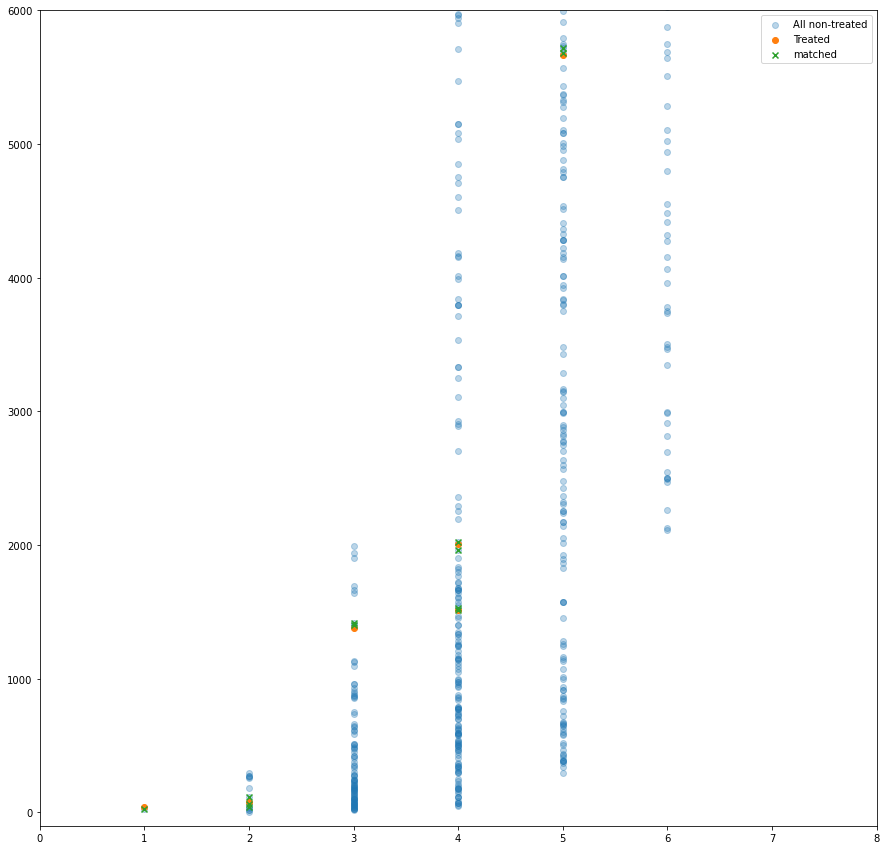

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(control_data['Product Count'], control_data['Category Sales'], alpha=0.3, label='All non-treated')
plt.scatter(treatment_data['Product Count'], treatment_data['Category Sales'], label='Treated')
plt.scatter(control_units_to_treatment_units['Control Product Count'], control_units_to_treatment_units['Control Category Sales'], marker='x', label='matched')
plt.legend()
plt.xlim(0,8)
plt.ylim(-100,6000)